# Tutorial / Proof of Concept for BDI+Kinetic Modeling

Please refer to infer_parameters.ipynb for more detailed comments.

This notebook just exists so that you can sample ER and LH models in parallel. Moreover, for the LH model we needed to somewhat modify the priors and guess LH_start_parameters.

# Packages

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pathos.multiprocessing import Pool

from convenience import reformat_local_parameters
from kineticmodel_bdi import KineticModel
from kineticmodel_bdi.bayesian_framework import Likelihood, FixStandardDeviation
from kineticmodel_bdi.sampling import UniformMinMax, SamplingEnvironment, sample_until_convergence

# Define model

## reactions

Every reaction is a list:

1. The first entry is a dictionary with all educts and their stoichiometry.
2. The second entry is a dictionary with all products and their stoichiometry.
3. The last entry is a string containing the name of the rate constant.

In [2]:
adsorption_equilibrium =  [[{'A': 1, 'S': 1}, {'AS': 1}, 'ka'],
                           [{'AS': 1}, {'A': 1, 'S': 1}, 'kd']]

In [3]:
ER_reactions = copy.deepcopy(adsorption_equilibrium)
ER_reactions.append([{'A': 1, 'AS': 1}, {'A': 1, 'S': 1, 'P': 1}, 'k_ER'])

In [4]:
LH_reactions = copy.deepcopy(adsorption_equilibrium)
LH_reactions.append([{'AS': 2}, {'AS': 1, 'P': 1, 'S': 1}, 'k_LH'])

## Starting parameters

LH parameters are different from ER parameters, I found one "decent" set of starting positions. It's far off but does not fail/yield loglikelihood of -infinity.

In [5]:
LH_start_parameters_reduced = pd.read_csv('LH_guess.csv', names=['parm', 'val'])
LH_start_parameters_reduced.index = LH_start_parameters_reduced['parm']
LH_start_parameters_reduced = LH_start_parameters_reduced['val']
LH_start_parameters_reduced 

parm
KA           7.647041
S0          -7.878408
k           -2.646065
kd          -2.082480
sigma_ads   -8.656406
sigma_kin   -6.602888
Name: val, dtype: float64

Some parameters need to be calculated from other ones:

$k_a = k_d \cdot K_A$

We get the full set of parameters:

In [6]:
LH_start_parameters = reformat_local_parameters(LH_start_parameters_reduced)
LH_start_parameters

parm
KA            7.647041
S0           -7.878408
k            -2.646065
kd           -2.082480
sigma_ads    -8.656406
sigma_kin    -6.602888
ka            5.564562
k_LH         13.110752
k_ER          5.232343
Name: val, dtype: float64

# Recover parameters from data

## Read in data

We can have a short look at the data, don't worry, they'll be visualized later:

Columns are named after the starting concentrations of the experiment.
Species A is varied:

In [7]:
observed_kin_data = pd.read_csv('observed_kin_data.csv', index_col=0)
observed_kin_data.columns = observed_kin_data.columns.astype(float)
observed_kin_data.columns.name = 'A'
observed_kin_data

A,1e-06,2e-06,5e-06
time / s,,,
0,9.406331e-07,2.014820e-06,0.000005
60,9.721912e-07,1.605037e-06,0.000004
120,7.327506e-07,1.305339e-06,0.000003
180,5.121232e-07,1.140978e-06,0.000003
240,5.039900e-07,1.072163e-06,0.000003
300,3.852125e-07,6.834921e-07,0.000002
360,2.895409e-07,5.558534e-07,0.000002
420,6.202657e-08,3.572558e-07,0.000001
480,1.181282e-07,4.996623e-07,0.000001


In the equilibrium adsorption, there are concentrations of adsorbed molecule AS compared to concentrations of unbound A.

In [8]:
observed_eq_adsorption_data = pd.read_csv('observed_eq_adsorption_data.csv', index_col=0, names=['A', 'AS'])
observed_eq_adsorption_data = observed_eq_adsorption_data['AS']
observed_eq_adsorption_data

A
3.162278e-09    1.060498e-09
5.011872e-09    4.354685e-09
7.943282e-09    4.855858e-09
1.258925e-08    5.062885e-09
1.995262e-08    4.912332e-09
3.162278e-08    6.227394e-09
5.011872e-08    9.355558e-09
7.943282e-08    9.522401e-09
1.258925e-07    1.015636e-08
1.995262e-07    9.393047e-09
Name: AS, dtype: float64

For time-dependent adsorption we compare [AS] against time.

In [9]:
observed_td_adsorption_data = pd.read_csv('observed_td_adsorption_data.csv', index_col=0)
observed_td_adsorption_data.columns = observed_td_adsorption_data.columns.astype(float)
observed_td_adsorption_data.columns.name = 'A'
observed_td_adsorption_data

A,2.5e-08,5e-08
time / s,,
10.0,1.582637e-09,1.888604e-09
15.0,1.508550e-09,2.463989e-09
20.0,1.399799e-09,5.044939e-09
25.0,2.348757e-09,5.235563e-09
30.0,3.265425e-09,7.063814e-09
35.0,2.369515e-09,6.329771e-09
40.0,5.359529e-09,8.162859e-09
45.0,5.523869e-09,6.989624e-09
50.0,4.366309e-09,6.256948e-09


## Priors

We are going to assume uniform distributions as priors. We will cover 5 orders of magnitude into both directions because LH does not work well. In a real application, this process requires more thought, see the main text of our paper.

In [10]:
lower_boundaries = LH_start_parameters - 5
upper_boundaries = LH_start_parameters + 5

In [11]:
prior_distributions = {x: UniformMinMax(val_min=lower_boundaries[x], val_max=upper_boundaries[x]) 
                       for x in LH_start_parameters_reduced.index}

In [12]:
prior_distributions

{'KA': <workflows.kinetic_modeling.sampling.UniformMinMax at 0x7f8a5409e250>,
 'S0': <workflows.kinetic_modeling.sampling.UniformMinMax at 0x7f8a5409e690>,
 'k': <workflows.kinetic_modeling.sampling.UniformMinMax at 0x7f8a5409e9d0>,
 'kd': <workflows.kinetic_modeling.sampling.UniformMinMax at 0x7f8a5409e990>,
 'sigma_ads': <workflows.kinetic_modeling.sampling.UniformMinMax at 0x7f8a5409e950>,
 'sigma_kin': <workflows.kinetic_modeling.sampling.UniformMinMax at 0x7f8a5409ea10>}

## Prepare sampling

We're building the kinetic models and creating Likelihood objects.
The kinetic models predict concentrations based on the guess for the rate constants.

The Likelihood objects are wrapped around the kinetic models. They take the estimate of the concentrations from the kinetic models and evaluate $p(D|\theta)$ for them

### Kinetic data - LH model

Text(0,0.5,'[A] / M')

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/home/niklas/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


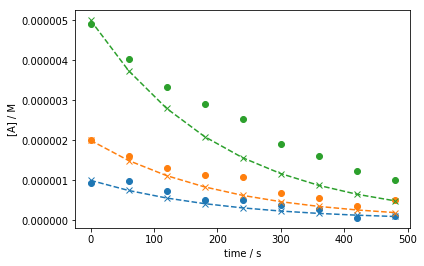

In [13]:
LH_model = KineticModel(observed_kin_data, LH_reactions, LH_start_parameters, educts=['A'])
LH_model.create_native_odesys()
LH_model.show_exp_data()
plt.ylabel('[A] / M')

In [14]:
LH_model.model

In [15]:
LH_likelihood = Likelihood(LH_model, FixStandardDeviation('sigma_kin'))

INFO:pyodesys.native._base:In "/tmp/tmpLoLFZx_pycodeexport_pyodesys_NativeCvodeCode", executing:
"/usr/bin/g++ -c -std=c++11 -Wall -Wextra -fPIC -O2 -ffast-math -funroll-loops -fopenmp -o ./odesys_anyode.o -I/home/niklas/anaconda2/lib/python2.7/site-packages/numpy/core/include -I/home/niklas/anaconda2/lib/python2.7/site-packages/pyodesys/native/sources -I/home/niklas/anaconda2/lib/python2.7/site-packages/pycvodes/include odesys_anyode.cpp"
INFO:pyodesys.native._base:In "/tmp/tmpLoLFZx_pycodeexport_pyodesys_NativeCvodeCode", executing:
"/usr/bin/g++ -pthread -shared -std=c++11 -Wall -Wextra -fPIC -O2 -ffast-math -funroll-loops -fopenmp -o /tmp/tmpLoLFZx_pycodeexport_pyodesys_NativeCvodeCode/_cvode_wrapper.so -I/home/niklas/anaconda2/lib/python2.7/site-packages/numpy/core/include -I/home/niklas/anaconda2/lib/python2.7/site-packages/pyodesys/native/sources -I/home/niklas/anaconda2/lib/python2.7/site-packages/pycvodes/include odesys_anyode.o _cvode_wrapper.o -lsundials_cvodes -lsundials_nv

In [16]:
LH_likelihood.pickle_dump_likelihood_specification('LH_likelihood.pkl', 'LH_model.pkl')

### Time-dependent adsorption

Text(0,0.5,'[AS] / M')

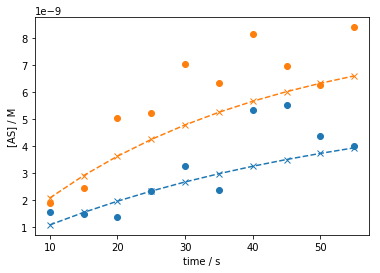

In [17]:
td_adsorption_model = KineticModel(observed_td_adsorption_data, adsorption_equilibrium, LH_start_parameters, educts=['A'], observed_species=['AS'])
td_adsorption_model.create_native_odesys()
td_adsorption_model.show_exp_data()
plt.ylabel('[AS] / M')

In [18]:
td_adsorption_likelihood = Likelihood(td_adsorption_model, FixStandardDeviation('sigma_ads'))

INFO:pyodesys.native._base:In "/tmp/tmpvvSDim_pycodeexport_pyodesys_NativeCvodeCode", executing:
"/usr/bin/g++ -c -std=c++11 -Wall -Wextra -fPIC -O2 -ffast-math -funroll-loops -fopenmp -o ./odesys_anyode.o -I/home/niklas/anaconda2/lib/python2.7/site-packages/numpy/core/include -I/home/niklas/anaconda2/lib/python2.7/site-packages/pyodesys/native/sources -I/home/niklas/anaconda2/lib/python2.7/site-packages/pycvodes/include odesys_anyode.cpp"
INFO:pyodesys.native._base:In "/tmp/tmpvvSDim_pycodeexport_pyodesys_NativeCvodeCode", executing:
"/usr/bin/g++ -pthread -shared -std=c++11 -Wall -Wextra -fPIC -O2 -ffast-math -funroll-loops -fopenmp -o /tmp/tmpvvSDim_pycodeexport_pyodesys_NativeCvodeCode/_cvode_wrapper.so -I/home/niklas/anaconda2/lib/python2.7/site-packages/numpy/core/include -I/home/niklas/anaconda2/lib/python2.7/site-packages/pyodesys/native/sources -I/home/niklas/anaconda2/lib/python2.7/site-packages/pycvodes/include odesys_anyode.o _cvode_wrapper.o -lsundials_cvodes -lsundials_nv

### Equilibrium adsorption

In [19]:
def langmuir_isotherm(A, KA, S0):
    KAA = A * KA
    return S0* KAA / (1 + KAA)

In [20]:
conc_A = observed_eq_adsorption_data.index.values

In [21]:
def calc_eq_adsorption(parameters):
    return langmuir_isotherm(conc_A, 10**parameters['KA'], 10**parameters['S0'])

Text(0,0.5,'[A] / M')

Text(0,0.5,'[AS] / M')

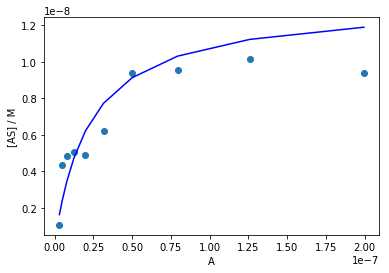

In [22]:
observed_eq_adsorption_data.plot(style='o')
plt.plot(conc_A, calc_eq_adsorption(LH_start_parameters), c='b')
plt.ylabel('[A] / M')
plt.ylabel('[AS] / M')

In [23]:
eq_adsorption_likelihood = Likelihood(calc_eq_adsorption, FixStandardDeviation('sigma_ads'), exp_data_formatted=observed_eq_adsorption_data)

# Sampling

We need to define functions that call calc_likelihood from Likelihood Objects.
Without this step, emcee cannot be parallelized because calc_likelihood cannot be pickled. This behavior is a bit odd but no big problem to circumvent.

In [24]:
def logp_ER(parameters):
    return ER_likelihood.calc_likelihood(parameters)

def logp_LH(parameters):
    return LH_likelihood.calc_likelihood(parameters)

def logp_td_adsorption(parameters):
    return td_adsorption_likelihood.calc_likelihood(parameters)

def logp_eq_adsorption(parameters):
    return eq_adsorption_likelihood.calc_likelihood(parameters)

Sampling settings

In [25]:
# emcee uses walkers to explore the posterior landscape, see their publication
nwalkers = 500
nsteps_test = 1
# what's the upper limit for steps to do?
nsteps = 40000
# only store every n-th step to the file to avoid bloat
thin_by = 50

We can evaluate the three experiments individually or jointly:

In [26]:
dict_list = [['eq', {'eq_adsorption': logp_eq_adsorption}],
             ['td', {'td_adsorption': logp_td_adsorption}],
             ['LH', {'LH': logp_LH}],
             ['LH_eq', {'LH': logp_LH, 'eq_adsorption': logp_eq_adsorption}],
             ['LH_eq_td', {'LH': logp_LH, 'eq_adsorption': logp_eq_adsorption, 'td_adsorption': logp_td_adsorption}]]

Create a so-called SamplingEnvironment for every case:

This will be handy to create a sampler, pass on the prior_distributions etc.

In [27]:
env_list = []

for x in dict_list:
    curr_name = x[0]
    curr_dict = x[1]
    curr_entry = [x[0]]
    curr_prior = prior_distributions
#     if 'ER' in curr_dict.keys():
#         curr_prior = prior_functions_ER
#     elif 'LH' in curr_dict.keys():
#         curr_prior = prior_functions_LH
    
    curr_env = SamplingEnvironment(curr_prior, curr_dict, reformat_local_parameters)
    
    env_list.append([curr_name, curr_env])

In [28]:
env_list

[['eq',
 ['td',
 ['LH',
 ['LH_eq',
 ['LH_eq_td',

# Generate Pool if calculations are supposed to be parralelized

In [29]:
local_pool = Pool(processes=4)

/home/niklas/python_packages/workflows/kinetic_modeling/bayesian_framework.py:136: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(individual_likelihoods).sum()
/home/niklas/python_packages/workflows/kinetic_modeling/bayesian_framework.py:136: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(individual_likelihoods).sum()
/home/niklas/python_packages/workflows/kinetic_modeling/bayesian_framework.py:136: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(individual_likelihoods).sum()
/home/niklas/python_packages/workflows/kinetic_modeling/bayesian_framework.py:136: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(individual_likelihoods).sum()


In [30]:
def choose_pool(name):
    # evaluation langmuire isotherm is very fast, parallelization is slowing it down
    if name == 'eq.h5':
        return None
    else:
        return local_pool

## Prepare everything

In [31]:
def do_sampling(environment, storage_name, sel_nsteps):
    curr_pool = choose_pool(storage_name)
    sampler = environment.setup_sampler(nwalkers, sel_pool=curr_pool, filename=storage_name)
    start_pos = environment.resume_positions_or_create_new_ones(sampler)
    sample_until_convergence(sampler, sel_nsteps, start_pos, thin_by=thin_by)

In [32]:
def make_sure_it_works(environment, storage_name):
    success = False
    while not success:
#         try:
        # We need to generate different starting points
        do_sampling(environment, storage_name, nsteps_test)
        success = True
#         except:
#             success = False

In [33]:
for x in env_list:
    store = x[0] + '.h5'
    make_sure_it_works(x[1], store)

/home/niklas/python_packages/workflows/kinetic_modeling/bayesian_framework.py:136: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(individual_likelihoods).sum()
100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


### Production

In [34]:
for x in env_list:
    store = x[0] + '.h5'
    print x[1]
    # We need to generate different starting points
    do_sampling(x[1], store, nsteps)

  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

  2%|▏         | 42450/2000000 [2:08:44<96:54:32,  5.61it/s] 


  1%|▏         | 27450/2000000 [1:51:31<127:36:07,  4.29it/s]


  3%|▎         | 59950/2000000 [4:56:45<157:31:48,  3.42it/s]


  6%|▌         | 117450/2000000 [14:57:44<225:42:20,  2.32it/s]
